<a href="https://colab.research.google.com/github/Shre20-create/Customer-Churn-Prediction-ML-/blob/main/Customer_Churn_Prediction_(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import xgboost as xgb

# Load the dataset
df = pd.read_csv('/content/telecom_churn.csv')

# Display first few rows and info
print(df.head())
print(df.info())
# Separate target variable (y) from features (X)
X = df.drop('Churn', axis=1)
y = df['Churn']
# Identify column types
numerical_features = ['AccountWeeks', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins']
categorical_features = ['ContractRenewal', 'DataPlan'] # Already 0/1, but will be handled as categorical

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a column transformer to apply different transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

   Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1        2.7              1   
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   
3      0            84                0         0        0.0              2   
4      0            75                0         0        0.0              3   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------ 

###2. Model Building and Training

In [4]:
# Define the model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Create the full pipeline
churn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', model)])

# Train the model
churn_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:03:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AccountWeeks', 'DataUsage',
                                                   'CustServCalls', 'DayMins',
                                                   'DayCalls', 'MonthlyCharge',
                                                   'OverageFee', 'RoamMins']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['ContractRenewal',
                                                   'DataPlan'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=No...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

####3. Model Evaluation

### Classification Report ###
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       570
           1       0.76      0.63      0.69        97

    accuracy                           0.92       667
   macro avg       0.85      0.80      0.82       667
weighted avg       0.91      0.92      0.91       667


AUC-ROC Score: 0.8319


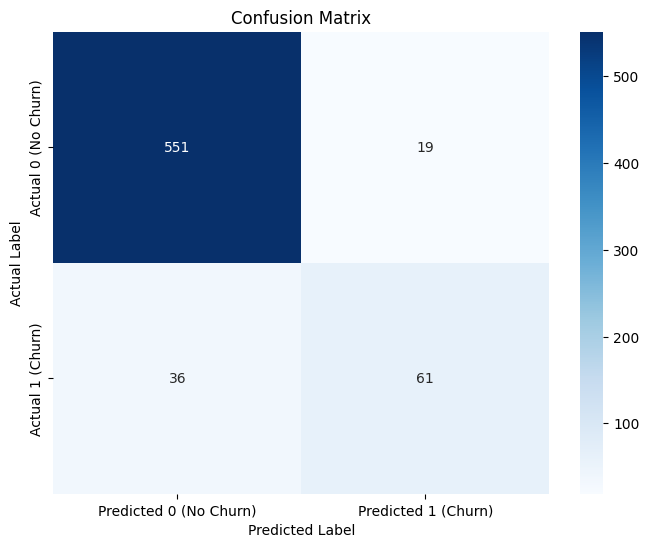

In [5]:
# Make predictions
y_pred = churn_pipeline.predict(X_test)
y_proba = churn_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("### Classification Report ###")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (No Churn)', 'Predicted 1 (Churn)'],
            yticklabels=['Actual 0 (No Churn)', 'Actual 1 (Churn)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

####4. Model Explainability with SHAP

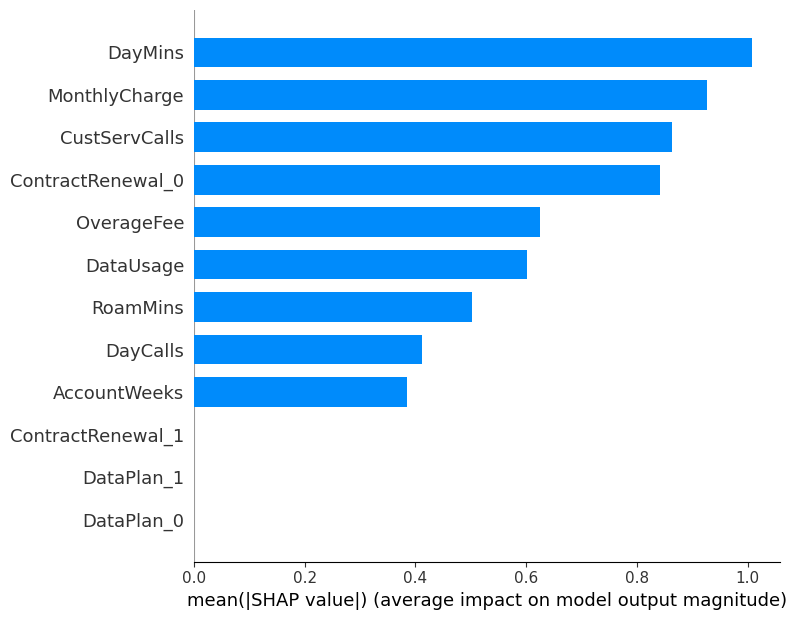

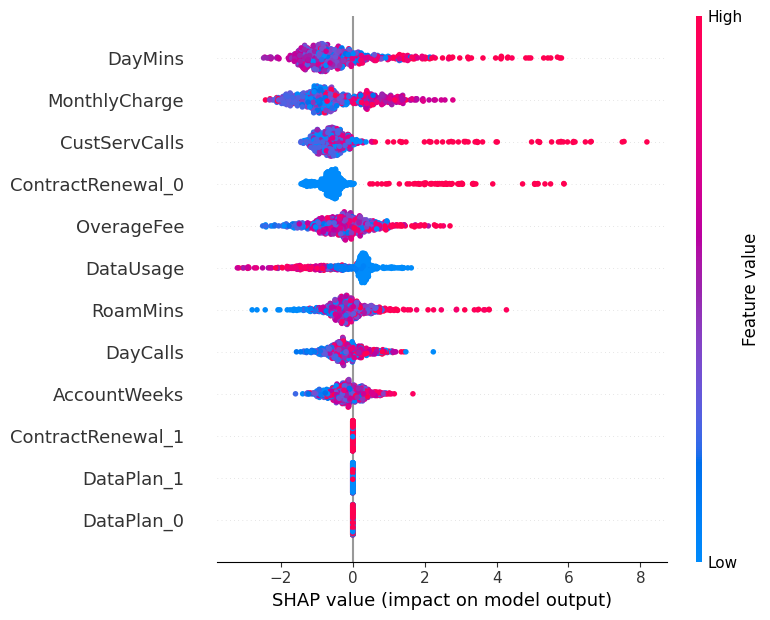

Original Data for Explained Customer:
AccountWeeks        62.00
ContractRenewal      0.00
DataPlan             0.00
DataUsage            0.00
CustServCalls        0.00
DayMins            159.70
DayCalls            86.00
MonthlyCharge       44.00
OverageFee           9.88
RoamMins            13.90
Name: 601, dtype: float64


In [8]:
# Get the preprocessed feature names
# This requires knowing the names generated by the OneHotEncoder
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Transform the test data
X_test_processed = churn_pipeline['preprocessor'].transform(X_test)

# SHAP explainer
explainer = shap.TreeExplainer(churn_pipeline['classifier'])
shap_values = explainer.shap_values(X_test_processed)
# Plot the summary (feature importance)
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, plot_type="bar")
# Plot the summary (beeswarm) to see impact direction
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)
# Find the index of the first predicted churner
churn_index = np.where(y_pred == 1)[0][0]
X_test_churner = X_test_processed[churn_index, :]
original_row = X_test.iloc[churn_index]

# Display the local explanation
print(f"Original Data for Explained Customer:\n{original_row}")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[churn_index], X_test_churner, feature_names=feature_names)